In [1]:
import pandas as pd
import numpy as np
!pip install beautifulsoup4
!pip install lxml
!pip install requests
from bs4 import BeautifulSoup
import requests
import matplotlib.pyplot as plt

<h1>Necessary data scraping <h1\>

In [2]:
source1 = requests.get('https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M').text

bs1 = BeautifulSoup(source1, 'lxml')

tot1 = []

for tab in bs1.find_all('td'):
    tot1.append(tab.text)

#Creating lists that correspond to the future columns in the dataframe. This is done by taking every 3rd element from the obtained list of all element
#starting at correct location. Finally removing leftover rows from other tables on the page

col11 = tot1[0::3]
col21 = tot1[1::3] 
col31 = tot1[2::3]
col11 = col11[0:len(col11)-12:]
col21 = col21[0:len(col21)-11:]
col31 = col31[0:len(col31)-11:]

#Creating a dataframe

tor_tbl = pd.DataFrame()

tor_tbl['PostalCode'] = col11
tor_tbl['Borough'] = col21
tor_tbl['Neighborhood'] = col31

#Removing the leftover characters (\n) from the Neighborhood column
tor_tbl['Neighborhood'] = tor_tbl['Neighborhood'].str.split('\n')

#Due to split usage, lists are formed in the rows of Neighborhood column. Using below loop this is corrected for. ', ' is added to process future step easily
for i, ngb in zip(range(len(tor_tbl.Borough)), tor_tbl['Neighborhood']):
    ngb = ngb[0]
    tor_tbl['Neighborhood'][i] = ngb + ', '

#All rows of column Borough that contain Not Assigned are removed. 
Tor_tbl_DN = tor_tbl[tor_tbl['Borough']!= 'Not assigned']
Tor_tbl_DN.reset_index(drop = True, inplace = True)

#Data is grouped in the way that all rows of Neighborhood column are combined for same Postal Codes
gr_tortbl = Tor_tbl_DN.groupby(['PostalCode','Borough'])[['Neighborhood']].sum().reset_index()

#Since in the previous step ', ' was added so that with grouping/suming data in the Neighborhood column the new shape will be x, y, and not xy.
#In this ste ', ' is removed from the end of each row

for i, ng_str in zip(range(len(gr_tortbl)), gr_tortbl['Neighborhood']):
    ng_str = ng_str[0:len(ng_str)-2]
    gr_tortbl['Neighborhood'][i] = ng_str

#gr_tortbl.to_csv(r'Toronto_Neighborhoods.csv')

In [3]:
source = requests.get('https://en.wikipedia.org/wiki/Demographics_of_Toronto_neighbourhoods').text

#Scraping the table

bs = BeautifulSoup(source, 'lxml')
tot = []

for tab in bs.find_all('td'):
    tot.append(tab.text)

tot = tot[2:]
col1 = tot[0::13] #Neighborhood (every 13th value in the list corresponds to the Neighborhood column)
col2 = tot[3::13] #Population
col3 = tot[7::13] #Income
col4 = tot[10::13] #Language

#Stripping the \n from values in rows

def striping(col):
    
    for i, x in zip(range(len(col)),col):
        st = x.strip('\n')
        col[i] = st
    return(col)

#Cleaning the lists from leftover data

#Neighborhood
col1 = striping(col1)
column1 = col1[1:len(col1)-2:]
#Population
col2 = striping(col2)
column2 = col2[1:len(col2)-1:]
#income
col3 = striping(col3)
column3 = col3[1:len(col3)-1:]
#Language
col4 = striping(col4)
column4 = col4[1:len(col4)-1:]

<h1>Data processing<h1\>

In [4]:
# creating dataframe from the lists

New_tor = pd.DataFrame()
New_tor['Neighborhood'] = column1
New_tor['Population'] = column2
New_tor['Income'] = column3
New_tor['Second Language'] = column4
#Removing percantage value from each row in column Second Language, by spliting and taking the first value which is only text
New_tor['Second Language'] = New_tor['Second Language'].apply(lambda x: x.split(' ')[0])
#Numbers were written in form x,x, the fucntion is splitting it by ',' and combining both values
New_tor['Income'] = New_tor['Income'].apply(lambda x: int(x.split(',')[0]+x.split(',')[1]))

#Above procedure didnt work because some numbers did not contain ',' so following method was used
Population = []
for i, x in zip(range(len(New_tor['Population'])),New_tor['Population']):
    st = x.split(',')
    try:
        y = st[0]+ st[1]
        Population.append(float(y))
    except:
        y = st[0]
        Population.append(float(y))

New_tor['Population'] = Population

In [5]:
#Splitting function based on different symbols
signs = ['-',' – ',' -', "\\", '–','/']

#First each string is split based on symbol, then it is expanded, and stacked(puting the values that were expanded in columns in rows below eachother)
aaa = New_tor.set_index(['Population','Income','Second Language'])['Neighborhood'].str.split(signs[0], expand = True).stack()
#Reseting index and droping the new level column which contains numbers that were new names of columns after expanding, and after they were stacked
s_New_tor = aaa.reset_index().drop('level_3', axis = 1).rename(columns={0:'Neighborhood'})
#Continuing loop (had to do it this way so that loop would take s_New_tor values, and not New_tor)
for sign in signs[1:]:
    aa = s_New_tor.set_index(['Population','Income','Second Language'])['Neighborhood'].str.split(sign, expand = True).stack()
   
    s_New_tor = aa.reset_index().drop('level_3', axis = 1).rename(columns={0:'Neighborhood'})

s_New_tor.head()

,Population,Income,Second Language,Neighborhood
0,44577.0,25750,Cantonese,Agincourt
1,11656.0,35239,Polish,Alderwood
2,4355.0,19687,Cantonese,Alexandra Park
3,2513.0,245592,Russian,Allenby
4,17318.0,27546,Spanish,Amesbury


In [6]:
#Reading toronto geo name data 
Toronto_data = gr_tortbl

#Splitting the data so that Neighborhood column would contain the name of each Neighbourhood separate, and not combined as before
#Ofcours Borough and postal code stay the same
ss = Toronto_data.set_index(['PostalCode','Borough'])['Neighborhood'].str.split(', ', expand = True).stack()
split_tor = ss.reset_index().drop('level_2', axis = 1).rename(columns={0:'Neighborhood'})
split_tor[split_tor['Neighborhood'] == 'Not assigned']

#Not assigned values are equalized with borough
for i,r2,r3 in zip(range(len(split_tor['Borough'])),split_tor['Borough'],split_tor['Neighborhood']):
    if r3 == 'Not assigned':
        split_tor['Neighborhood'][i] = r2

In [7]:
#This block is testing which neighborhoods from the income table are not equal with neighborhoods in geo name table

nt_in = []

for nt in s_New_tor['Neighborhood']:
        x = (split_tor['Neighborhood'] == nt).astype('int')       
        for z in x:
            if z == 0:
                pass
            else:
                nt_in.append(nt)
                
pds = s_New_tor['Neighborhood'][~s_New_tor['Neighborhood'].isin(pd.Series(nt_in))]

In [8]:
#This is new dataframe which is used to further process income table
trial = s_New_tor
trial.shape
trial.drop(trial.index[11],axis = 0,inplace = True)

In [9]:
#These empty lists will be added rows in the income column
pop = []
inco = []
SL = []
ngbh = []

#The idea of this loop is to create new rows in income table which have neighborhoods that correspond to the similar neighborhoods in geo name table
#Example income table contains Steeles, but geo name has Steeles East, and South Steeles. Merging will not work, so income table will gain 2 new rows that 
#are for Steeles East and South, that have other values equal to Steeles.

#First all neighborhoods that do merge with geo name table -pds data frame- are looped through
#Then it is checked if geo name neighborhoods have a name that contains atleast part of neighborhood name from income table, like South Steeles contains Steeles
#The way it is coded, it will give either empty dataframe if there are no matches, or some values
#These values are then written in new lists where Neighborhood corresponds to name of geo name Neighborhood -e.g.Steeles East- while other parameters are equal to original value -Steeles-
for row in pds:
    s = split_tor[split_tor.apply(lambda x:  row in x['Neighborhood'], axis = 1)]
    if s.empty:
        pass
    else:
        tr = trial[trial['Neighborhood'] ==row]
        len_s = len(s['Neighborhood'])
        for i in s['Neighborhood']:
            #ntrial = trial.append({"Population":tr['Population'].reset_index(drop = True)[0],'Income':tr['Income'].reset_index(drop = True)[0],'Second Language':tr['Second Language'].reset_index(drop = True)[0],'Neighborhood':i},ignore_index=True)
            pop.append(tr['Population'].reset_index(drop = True)[0]/len_s)
            inco.append(tr['Income'].reset_index(drop = True)[0])
            SL.append(tr['Second Language'].reset_index(drop = True)[0])
            ngbh.append(i)

#New dataframe is created from those values
new_f = pd.DataFrame()
new_f['Population'] = pop
new_f['Income'] = inco
new_f['Second Language'] = SL
new_f['Neighborhood'] = ngbh
#This new dataframe is combined with the original income dataframe
s_New_tor = pd.concat([trial,new_f]).reset_index(drop = True)

<h2> Data analysis through visualisation <h2\>

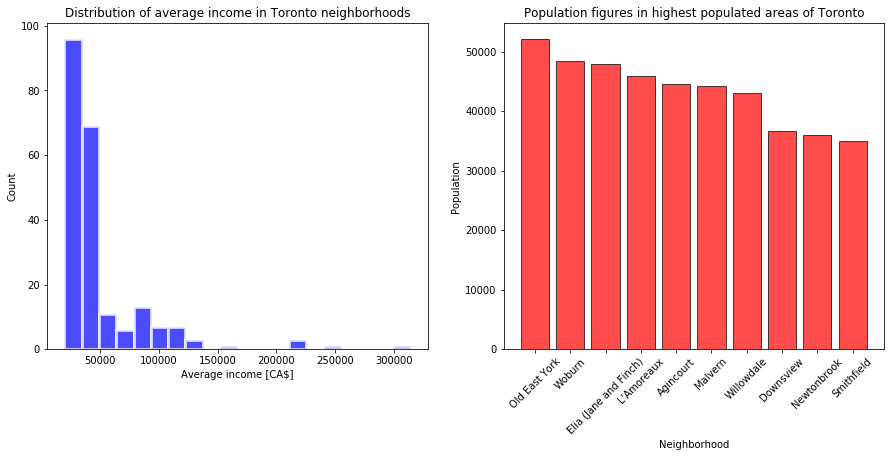

In [10]:
Inc = s_New_tor['Income'].astype('float').to_numpy()

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

ax[0].hist(Inc,bins=20,histtype='bar', color = 'blue', edgecolor = 'white', ls='solid', lw=3, alpha = 0.7)
ax[0].set_ylabel('Count')
ax[0].set_xlabel('Average income [CA$]')
ax[0].title.set_text('Distribution of average income in Toronto neighborhoods')



ax[1].bar(s_New_tor.sort_values(by='Population',ascending=False).loc[:,'Neighborhood'].head(10),s_New_tor['Population'].sort_values(ascending=False).head(10), color = 'red', edgecolor = 'black', alpha = 0.7)
ax[1].set_ylabel('Population')
ax[1].set_xlabel('Neighborhood')
ax[1].title.set_text('Population figures in highest populated areas of Toronto')

plt.xticks(rotation=45)

plt.show()

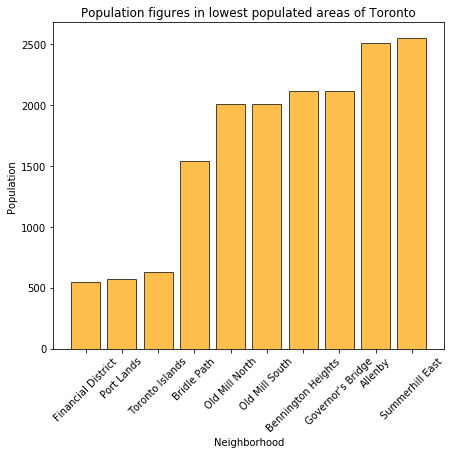

In [11]:
plt.figure(figsize=(7, 6))
plt.bar(s_New_tor.sort_values(by='Population',ascending=True).loc[:,'Neighborhood'].head(10),s_New_tor['Population'].sort_values(ascending=True).head(10), color = 'orange', edgecolor = 'black', alpha = 0.7)
plt.ylabel('Population')
plt.xlabel('Neighborhood')
plt.title('Population figures in lowest populated areas of Toronto')
plt.xticks(rotation=45)

plt.show()

In [12]:
import seaborn as sns

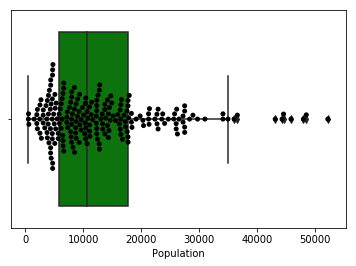

In [13]:
Tor_pop = 1

ax = sns.boxplot(x = s_New_tor['Population'], color = 'green', saturation = 0.8)
ax = sns.swarmplot(x = s_New_tor['Population'], color = 'black')


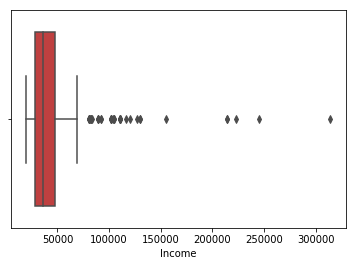

In [14]:
Tor_pop = 1

ax = sns.boxplot(x = s_New_tor['Income'], color = 'red', saturation = 0.5)
#ax = sns.swarmplot(x = s_New_tor['Income'], color = 'black')

In [15]:
#Finally income and geo name dfs are merged
Tor_data = split_tor.merge(s_New_tor).drop_duplicates().reset_index(drop = True)
Tor_data['Population'] = Tor_data['Population'].astype('int')
#Tor_data[Tor_data['Second Language']== 'None'].loc[60,'Second Language']
Tor_data.loc[60,'Second Language'] = 'Unspecified'
languages = Tor_data['Second Language'].value_counts()
lng1 = languages.to_frame().reset_index()

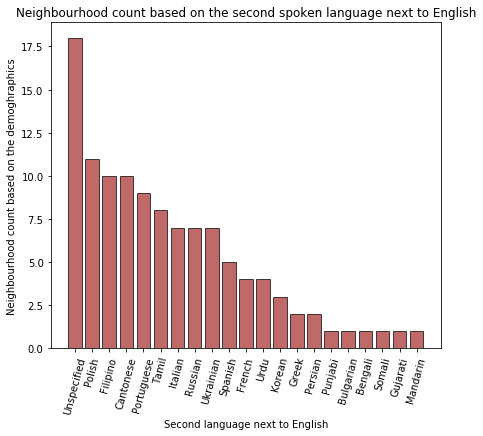

In [16]:
plt.figure(figsize=(7, 6))
plt.bar(lng1['index'],lng1['Second Language'], color = 'brown', edgecolor = 'black', alpha = 0.7)
plt.ylabel('Neighbourhood count based on the demoghraphics')
plt.xlabel('Second language next to English')
plt.title('Neighbourhood count based on the second spoken language next to English')
plt.xticks(rotation=75)

plt.show()

In [17]:
#Forming a list with geographical/cultural groups that correspond to the second language in the Tor_data df
culture = []

for etn in Tor_data['Second Language']:
    if etn == 'Unspecified':
        culture.append('Unspecified')
    elif etn == 'Polish':
        culture.append('Eastern European/Slavic')
    elif etn == 'Cantonese':
        culture.append('East Asian')
    elif etn == 'Filipino':
        culture.append('East Asian')
    elif etn == 'Portuguese':
        culture.append('South European / Romance')
    elif etn == 'Tamil':
        culture.append('South Asian / Indian')
    elif etn == 'Ukrainian':
        culture.append('Eastern European/Slavic')
    elif etn == 'Italian':
        culture.append('South European / Romance')
    elif etn == 'Russian':
        culture.append('Eastern European/Slavic')
    elif etn == 'Spanish':
        culture.append('South European / Romance')
    elif etn == 'Urdu':
        culture.append('South Asian / Indian')
    elif etn == 'French':
        culture.append('South European / Romance')
    elif etn == 'Korean':
        culture.append('East Asian')
    elif etn == 'Persian':
        culture.append('West Asian and African')
    elif etn == 'Greek':
        culture.append('South European / Romance')      
    elif etn == 'Gujarati':
        culture.append('South Asian / Indian')
    elif etn == 'Punjabi':
        culture.append('South Asian / Indian')
    elif etn == 'Bengali':
        culture.append('South Asian / Indian')
    elif etn == 'Mandarin':
        culture.append('East Asian')
    elif etn == 'Bulgarian':
        culture.append('Eastern European/Slavic')
    elif etn == 'Somali':
        culture.append('West Asian and African')
        
Tor_data['Geo/Cultural group'] = culture

#Creating a new DataFrame to ilustrate the classification of languages in to different geo/cultural groups

Geo_cul_data = Tor_data['Geo/Cultural group'].unique()
lang_df = pd.DataFrame()

for gcd in Geo_cul_data:
    column_n = Tor_data[Tor_data['Geo/Cultural group'] == gcd]
    val = column_n['Second Language'].unique()
    lst = []
    lst2 = []
    for v in val:
        lst.append(v)
    lst2.append(lst)
        
    lang_df[gcd] = lst2
    
stack_lang = lang_df.stack()
n_stack = pd.DataFrame(stack_lang).reset_index().drop('level_0',axis = 1)
nn_stack = n_stack.rename(columns = {"level_1":"Geo/Cultural group",0:'Language group'})
nn_stack['Label'] = [0,0,0,0,1,0]
nn_stack

,Geo/Cultural group,Language group,Label
0,South Asian / Indian,"[Tamil, Gujarati, Bengali, Urdu, Punjabi]",0
1,East Asian,"[Filipino, Cantonese, Mandarin, Korean]",0
2,West Asian and African,"[Persian, Somali]",0
3,Unspecified,[Unspecified],0
4,Eastern European/Slavic,"[Russian, Bulgarian, Ukrainian, Polish]",1
5,South European / Romance,"[Greek, French, Spanish, Portuguese, Italian]",0


In [18]:
Tdata = Tor_data.rename(columns={'Income':'Average income'})
Tdata.describe()


,Population,Average income
count,113.000000,113.000000
mean,14135.557522,48619.380531
std,9794.219106,33966.522451
min,627.000000,21155.000000
25%,7672.000000,28403.000000
50%,12348.000000,36361.000000
75%,17602.000000,48965.000000
max,48507.000000,214110.000000


In [19]:
Tor_data['Geo/Cultural group'].unique()

array(['South Asian / Indian', 'East Asian', 'West Asian and African',
       'Unspecified', 'Eastern European/Slavic',
       'South European / Romance'], dtype=object)

In [20]:
grouping = Tor_data['Geo/Cultural group'].value_counts()
geo_grp = grouping.to_frame().reset_index()

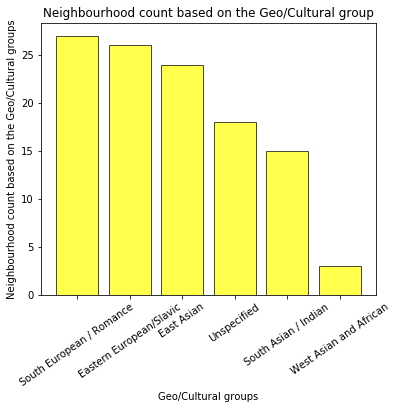

In [21]:
plt.figure(figsize=(6, 5))
plt.bar(geo_grp['index'],geo_grp['Geo/Cultural group'], color = 'yellow', edgecolor = 'black', alpha = 0.7)
plt.ylabel('Neighbourhood count based on the Geo/Cultural groups')
plt.xlabel('Geo/Cultural groups')
plt.title('Neighbourhood count based on the Geo/Cultural group')
plt.xticks(rotation=35)

plt.show()

In [22]:
#Giving labels to each Geo/Cultural group in order to do clustering/clasification

Tor_data['Numbered_groups'] = 0

for i, gcg in zip(range(len(Tor_data['Geo/Cultural group'])),Tor_data['Geo/Cultural group']):
    if gcg == 'South Asian / Indian':
        Tor_data.loc[i,'Numbered_groups'] = 0
    elif gcg == 'East Asian':
        Tor_data.loc[i,'Numbered_groups'] = 1
    elif gcg == 'West Asian and African':
        Tor_data.loc[i,'Numbered_groups'] = 2
    elif gcg == 'Unspecified':
        Tor_data.loc[i,'Numbered_groups'] = -1
    elif gcg == 'Eastern European/Slavic':
        Tor_data.loc[i,'Numbered_groups'] = 3
    elif gcg == 'South European / Romance':
        Tor_data.loc[i,'Numbered_groups'] = 4

Tor_data1 = Tor_data.rename(columns={'Numbered_groups':'Geo/Cul labels'})

In [23]:
!pip install geocoder
import geocoder 

     |████████████████████████████████| 102kB 7.4MB/s ta 0:00:011


In [24]:
#Obtaining latitude/ longitude data for each area of Toronto

latitude = []
longitude = []

for pc in Tor_data1['PostalCode']:
    g = geocoder.arcgis('{}, Toronto, Ontario'.format(pc))
    lat_lng_coords = g.latlng
    latitude.append(lat_lng_coords[0])
    longitude.append(lat_lng_coords[1])
    
Tor_data1['latitude'] = latitude
Tor_data1['longitude'] = longitude

In [25]:
!conda install -c conda-forge folium=0.5.0 --yes
import folium
from sklearn.cluster import KMeans 
from sklearn.preprocessing import StandardScaler
import matplotlib.cm as cm
import matplotlib.colors as colors

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - folium=0.5.0


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    certifi-2019.11.28         |           py36_0         149 KB  conda-forge
    ca-certificates-2019.11.28 |       hecc5488_0         145 KB  conda-forge
    branca-0.4.0               |             py_0          26 KB  conda-forge
    openssl-1.1.1d             |       h516909a_0         2.1 MB  conda-forge
    vincent-0.4.4              |             py_1          28 KB  conda-forge
    folium-0.5.0               |             py_0          45 KB  conda-forge
    altair-4.0.1               |             py_0         575 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         3.0 MB

The following NEW packages will be 

<h3>Data visualisation with folium<h3\>

In [54]:
#Visualisation of Toronto neighborhoods based on the population size. The size of a circle marker is proportional to the population size

tor_lat = 43.651070
tor_long = -79.347015

map_Toronto = folium.Map(location=[tor_lat, tor_long], zoom_start=11)

rainbow = ['orange', 'blue', 'grey', 'green', 'red', 'yellow']

norm_pop = Tor_data1['Population']/Tor_data1['Population'].mean()

#Since several neighborhoods fall in the same postalcodes, it can be notices that there are many circles inside circles representing different neighborhoods

for lat, lng, label1, label2, size, popul in zip(Tor_data1['latitude'], Tor_data1['longitude'], Tor_data1['Geo/Cultural group'], Tor_data1['Neighborhood'], Tor_data1['Geo/Cul labels'], norm_pop):
    label = folium.Popup(label2 + '(' + label1 + ',' + ' '+ "norm.population =" + str(round(popul, 2)) + ')', parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        #radius=popul**2,
        radius=size/2+15/(size**2 + 2) + popul**2,
        popup=label,
        color=rainbow[size],
        fill=False,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_Toronto)
    
map_Toronto

In [27]:
#Visualisation of Toronto neighborhoods based on the average income. The size of a circle marker is proportional to the average income

tor_lat = 43.651070
tor_long = -79.347015

map_Toronto2 = folium.Map(location=[tor_lat, tor_long], zoom_start=11)

rainbow = ['orange', 'blue', 'grey', 'green', 'red', 'yellow']

norm_inc = Tor_data1['Income']/Tor_data1['Income'].mean()

for lat, lng, label1, label2, size, inc, r_inc in zip(Tor_data1['latitude'], Tor_data1['longitude'], Tor_data1['Geo/Cultural group'], Tor_data1['Neighborhood'], Tor_data1['Geo/Cul labels'], norm_inc, Tor_data1['Income']):
    label = folium.Popup(label2 + '(' + label1 + ',' + ' '+ "Average Income =" + str(round(r_inc, 2)) + ')', parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=inc*3+1,
        popup=label,
        color=rainbow[size],
        fill=False,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_Toronto2)
    
map_Toronto2

<h1> Custering and Clasification <h1\>

In [28]:
for i, gcg in zip(range(len(Tor_data1['Geo/Cultural group'])),Tor_data1['Geo/Cultural group']):
    if gcg == 'South Asian / Indian':
        Tor_data1.loc[i,'Numbered_groups'] = 0
    elif gcg == 'East Asian':
        Tor_data1.loc[i,'Numbered_groups'] = 0
    elif gcg == 'West Asian and African':
        Tor_data1.loc[i,'Numbered_groups'] = 0
    elif gcg == 'Unspecified':
        Tor_data1.loc[i,'Numbered_groups'] = 0
    elif gcg == 'Eastern European/Slavic':
        Tor_data1.loc[i,'Numbered_groups'] = 1
    elif gcg == 'South European / Romance':
        Tor_data1.loc[i,'Numbered_groups'] = 0

In [29]:
from sklearn.cluster import DBSCAN

#Clustering of neighborhoods was performed using KMeans tool, DBSCAN gives similar results

x = Tor_data1[['Population','Income', 'Numbered_groups']]

num_clusters = 10
x = StandardScaler().fit_transform(x)

k_means = KMeans(init="k-means++", n_clusters=num_clusters, n_init=12)
k_means.fit(x)

#db = DBSCAN(eps = 0.4, min_samples = 3)
#db.fit(x)

#labels = db.labels_
labels = k_means.labels_
labels

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


array([2, 7, 5, 5, 5, 5, 5, 2, 7, 5, 5, 5, 5, 5, 0, 5, 5, 0, 5, 7, 2, 2,
       2, 2, 5, 2, 5, 0, 5, 6, 8, 7, 2, 0, 2, 0, 1, 5, 5, 5, 6, 4, 5, 0,
       2, 3, 2, 9, 9, 4, 4, 9, 9, 3, 0, 5, 5, 5, 0, 6, 0, 6, 4, 4, 6, 9,
       0, 0, 6, 0, 0, 5, 2, 2, 0, 0, 0, 7, 2, 5, 0, 1, 1, 0, 8, 1, 1, 1,
       1, 1, 1, 1, 4, 4, 1, 4, 0, 1, 1, 0, 5, 6, 1, 0, 1, 5, 0, 5, 1, 5,
       2, 5, 5], dtype=int32)

In [30]:
Tor_data1['Labels'] = labels

In [31]:
#These are the parameters that are used to find the best suited neighborhood. They are based on characteristics of ideal neighborhood, which has moderate to high population, mean average income
#and is in eastern european group

t_pop = (Tor_data1['Population'].max() - Tor_data1['Population'].mean())/2 + Tor_data1['Population'].mean()   #High population, equal to the 2/3 of a distance between mean and max value
t_inc = Tor_data1['Income'].mean()    #Middle income neighborhood
t_gc = 1    # 3 corresponds to Eastern European group as described before

test_list = [t_pop, t_inc, t_gc]
test_list

[31321.278761061945, 48619.38053097345, 1]

In [32]:
#Combining Xtrain and Xtest to be scaled together

x2 = Tor_data1[['Population','Income', 'Numbered_groups']]
pop_col = x2['Population'].to_list()
pop_col.append(t_pop)

inc_col = x2['Income'].to_list()
inc_col.append(t_inc)

gc_col = x2['Numbered_groups'].to_list()
gc_col.append(t_gc)

x3 = pd.DataFrame()

x3['Population'] = pop_col
x3['Income'] = inc_col
x3['Numbered_groups'] = gc_col

x3 = StandardScaler().fit_transform(x3)

In [33]:
#Separating Xtrain and Xtest now that they are scaled

X_train = x3[:-1]
X_try = x3[[-1]]
y_train = Tor_data1['Labels']

In [34]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm

#Using logistic regression for clasification, other methods give similar results depending on the given parameters

lr = LogisticRegression(C=0.01, solver = 'liblinear')
#kn = KNeighborsClassifier(n_neighbors = 10)
#sv_m = svm.SVC(kernel = 'sigmoid')

In [35]:
#Fitting/predicting

lr.fit(X_train, y_train)
y_pred = lr.predict(X_try)

#This value will give a cluster of neighborhoods which is closest to ideal one
y_pred[0]

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


1

In [36]:
#The neighborhoods in the cluster closest to ideal one are visualized

tor_lat = 43.651070
tor_long = -79.347015

map_Toronto_cluster = folium.Map(location=[tor_lat, tor_long], zoom_start=11)


for lat, lng, label1, label2, size, popul, clust in zip(Tor_data1['latitude'], Tor_data1['longitude'], Tor_data1['Geo/Cultural group'], Tor_data1['Neighborhood'], Tor_data1['Geo/Cul labels'], norm_pop, Tor_data1['Labels']):
    if clust == y_pred[0]:
        label = folium.Popup(label2 + '(' + label1 + ')', parse_html=True)
        folium.CircleMarker(
            [lat, lng],
            radius= 4 + popul**3,
            popup=label,
            color='Black',
            fill=True,
            fill_color='#3186cc',
            fill_opacity=0.7,
            parse_html=False).add_to(map_Toronto_cluster)
    else:
        pass
    
map_Toronto_cluster

In [37]:
#Neighborhoods from cluster are isolated and will be further worked on

grouped_tor_data = Tor_data1[Tor_data1['Labels'] == y_pred[0]].reset_index(drop = True)
grouped_tor_data.sort_values(by='Population', ascending=False)

,PostalCode,Borough,Neighborhood,Population,Income,Second Language,Geo/Cultural group,Geo/Cul labels,latitude,longitude,Numbered_groups,Labels
11,M8Y,Etobicoke,Sunnylea,17602,51398,Polish,Eastern European/Slavic,3,43.632835,-79.489550,1.0,1
3,M6R,West Toronto,Roncesvalles,15996,46820,Polish,Eastern European/Slavic,3,43.647870,-79.449776,1.0,1
0,M3H,North York,Bathurst Manor,14945,34169,Russian,Eastern European/Slavic,3,43.757875,-79.448688,1.0,1
8,M8W,Etobicoke,Alderwood,11656,35239,Polish,Eastern European/Slavic,3,43.601131,-79.538785,1.0,1
4,M6S,West Toronto,Swansea,11133,58681,Polish,Eastern European/Slavic,3,43.649620,-79.476141,1.0,1
5,M8V,Etobicoke,Humber Bay Shores,10775,39186,Russian,Eastern European/Slavic,3,43.612200,-79.495146,1.0,1
7,M8V,Etobicoke,New Toronto,10455,33415,Polish,Eastern European/Slavic,3,43.612200,-79.495146,1.0,1
14,M9C,Etobicoke,Markland Wood,10240,51695,Polish,Eastern European/Slavic,3,43.648573,-79.578250,1.0,1
9,M8W,Etobicoke,Long Branch,9625,37288,Polish,Eastern European/Slavic,3,43.601131,-79.538785,1.0,1
15,M9P,Etobicoke,Westmount,5857,35183,Ukrainian,Eastern European/Slavic,3,43.696505,-79.530252,1.0,1


<h1> FourSquare / competition analysis <h1\>

In [38]:
#Function for obtaining venues in the given area

def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [39]:
#FourSquare authentication

CLIENT_ID = 'NGHBQH43VSZTK3E4LCW0R10Z3WKO1CXBCPLDHTEWZ14VG0VF' 
CLIENT_SECRET = 'RS2IFCZJDPOMSQOAX1CJI0P2UO4SPZKDO5PACCSP330AHMNW' 
VERSION = '20180605'
LIMIT = 100

In [40]:
#Calling the foursquare function

Toronto_venues = getNearbyVenues(names=grouped_tor_data['Neighborhood'],
                                   latitudes=grouped_tor_data['latitude'],
                                   longitudes=grouped_tor_data['longitude']
                                  )

Bathurst Manor
Runnymede
Runnymede
Roncesvalles
Swansea
Humber Bay Shores
Mimico South
New Toronto
Alderwood
Long Branch
Mimico NE
Sunnylea
Mimico NW
West Deane Park
Markland Wood
Westmount


In [41]:
#All obtained eastern european restaurants in the toronto area

Toronto_venues[Toronto_venues.apply(lambda x:  'Eastern European Restaurant' in x['Venue Category'], axis = 1)].drop(['Neighborhood Latitude','Neighborhood Longitude'], axis = 1)

,Neighborhood,Venue,Venue Latitude,Venue Longitude,Venue Category
56,Roncesvalles,Inter Steer,43.649796,-79.450310,Eastern European Restaurant
59,Roncesvalles,Café Polonez,43.645113,-79.448517,Eastern European Restaurant
88,Roncesvalles,Chopin Restaurant,43.644165,-79.448162,Eastern European Restaurant
196,Mimico NW,Zam,43.620798,-79.528265,Eastern European Restaurant


<h1> Elimination of competetive neighborhoods <h1\>

In [42]:
#The neighborhoods with competition are eliminated

index1 = grouped_tor_data[grouped_tor_data['Neighborhood'] == 'Roncesvalles'].index[0]
index2 = grouped_tor_data[grouped_tor_data['Neighborhood'] == 'Mimico NW'].index[0]
t_g_data = grouped_tor_data

el_grp_tor_data = t_g_data.drop([index1,index2], axis = 0).reset_index(drop = True)

In [43]:
el_grp_tor_data

,PostalCode,Borough,Neighborhood,Population,Income,Second Language,Geo/Cultural group,Geo/Cul labels,latitude,longitude,Numbered_groups,Labels
0,M3H,North York,Bathurst Manor,14945,34169,Russian,Eastern European/Slavic,3,43.757875,-79.448688,1.0,1
1,M6N,York,Runnymede,4382,42635,Ukrainian,Eastern European/Slavic,3,43.676125,-79.481932,1.0,1
2,M6S,West Toronto,Runnymede,4382,42635,Ukrainian,Eastern European/Slavic,3,43.649620,-79.476141,1.0,1
3,M6S,West Toronto,Swansea,11133,58681,Polish,Eastern European/Slavic,3,43.649620,-79.476141,1.0,1
4,M8V,Etobicoke,Humber Bay Shores,10775,39186,Russian,Eastern European/Slavic,3,43.612200,-79.495146,1.0,1
5,M8V,Etobicoke,Mimico South,4732,47011,Polish,Eastern European/Slavic,3,43.612200,-79.495146,1.0,1
6,M8V,Etobicoke,New Toronto,10455,33415,Polish,Eastern European/Slavic,3,43.612200,-79.495146,1.0,1
7,M8W,Etobicoke,Alderwood,11656,35239,Polish,Eastern European/Slavic,3,43.601131,-79.538785,1.0,1
8,M8W,Etobicoke,Long Branch,9625,37288,Polish,Eastern European/Slavic,3,43.601131,-79.538785,1.0,1
9,M8Y,Etobicoke,Mimico NE,4732,47011,Polish,Eastern European/Slavic,3,43.632835,-79.489550,1.0,1


<h1> Predicting top 3 locations <h1\>

In [44]:
#Top 3 locations will be predicted by using logical regression. Each neighborhood will be classified as a single cluster. 
log_reg = LogisticRegression(C=0.01, solver = 'liblinear')

In [45]:
Labs = np.arange(0,14,1)
el_grp_tor_data['Labels'] = Labs

In [46]:
#Training the data set in order to predict the top 3 locations for the restaurant based on the probabilities from logical regression

#Adding data for scaling
X_4 = el_grp_tor_data[['Population', 'Income']]

t_pop = [(Tor_data1['Population'].max() - Tor_data1['Population'].mean())/2 + Tor_data1['Population'].mean()]   #High population, equal to the 2/3 of a distance between mean and max value
t_inc = [Tor_data1['Income'].mean()]    #Middle income neighborhood

new_df = pd.DataFrame()
new_df['Population'] = t_pop
new_df['Income'] = t_inc
new_df

X_scale = pd.concat([X_4, new_df], ignore_index = True)
#X
x_scaled = StandardScaler().fit_transform(X_scale)

X_train_rest = x_scaled[:-1]
X_test = x_scaled[[-1]]
#Y
y_train_rest = el_grp_tor_data['Labels']

log_reg.fit(X_train_rest, y_train_rest)

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False)

In [47]:
#This time predicted cluster will correspond to a specific neighborhood which would be the neighborhood with the highest probability of being an ideal restaurant location
y_predicted = log_reg.predict(X_test)
y_predicted 

array([10])

In [48]:
el_grp_tor_data.drop(['Numbered_groups', 'Geo/Cul labels'], axis = 1)

,PostalCode,Borough,Neighborhood,Population,Income,Second Language,Geo/Cultural group,latitude,longitude,Labels
0,M3H,North York,Bathurst Manor,14945,34169,Russian,Eastern European/Slavic,43.757875,-79.448688,0
1,M6N,York,Runnymede,4382,42635,Ukrainian,Eastern European/Slavic,43.676125,-79.481932,1
2,M6S,West Toronto,Runnymede,4382,42635,Ukrainian,Eastern European/Slavic,43.649620,-79.476141,2
3,M6S,West Toronto,Swansea,11133,58681,Polish,Eastern European/Slavic,43.649620,-79.476141,3
4,M8V,Etobicoke,Humber Bay Shores,10775,39186,Russian,Eastern European/Slavic,43.612200,-79.495146,4
5,M8V,Etobicoke,Mimico South,4732,47011,Polish,Eastern European/Slavic,43.612200,-79.495146,5
6,M8V,Etobicoke,New Toronto,10455,33415,Polish,Eastern European/Slavic,43.612200,-79.495146,6
7,M8W,Etobicoke,Alderwood,11656,35239,Polish,Eastern European/Slavic,43.601131,-79.538785,7
8,M8W,Etobicoke,Long Branch,9625,37288,Polish,Eastern European/Slavic,43.601131,-79.538785,8
9,M8Y,Etobicoke,Mimico NE,4732,47011,Polish,Eastern European/Slavic,43.632835,-79.489550,9


In [49]:
#Looking at probabilities for each cluster/neighborhood it can be seen that all neighborhoods are very close
y_proba = log_reg.predict_proba(X_test)
y_proba

array([[0.07207163, 0.0707106 , 0.0707106 , 0.07236099, 0.07159521,
        0.07092504, 0.07133471, 0.07159083, 0.07134445, 0.07092504,
        0.07311821, 0.07067436, 0.07196573, 0.07067259]])

In [50]:
el_grp_tor_data['Probabilities %'] = y_proba[0]*100

In [51]:
#Presenting the probabilities in the table

Toronto_restaurant_prob_data = el_grp_tor_data.sort_values(by = 'Probabilities %', ascending = False)
Toronto_restaurant_prob_data.drop(['Numbered_groups','Geo/Cul labels', 'Second Language', 'latitude','longitude'],axis = 1)

,PostalCode,Borough,Neighborhood,Population,Income,Geo/Cultural group,Labels,Probabilities %
10,M8Y,Etobicoke,Sunnylea,17602,51398,Eastern European/Slavic,10,7.311821
3,M6S,West Toronto,Swansea,11133,58681,Eastern European/Slavic,3,7.236099
0,M3H,North York,Bathurst Manor,14945,34169,Eastern European/Slavic,0,7.207163
12,M9C,Etobicoke,Markland Wood,10240,51695,Eastern European/Slavic,12,7.196573
4,M8V,Etobicoke,Humber Bay Shores,10775,39186,Eastern European/Slavic,4,7.159521
7,M8W,Etobicoke,Alderwood,11656,35239,Eastern European/Slavic,7,7.159083
8,M8W,Etobicoke,Long Branch,9625,37288,Eastern European/Slavic,8,7.134445
6,M8V,Etobicoke,New Toronto,10455,33415,Eastern European/Slavic,6,7.133471
5,M8V,Etobicoke,Mimico South,4732,47011,Eastern European/Slavic,5,7.092504
9,M8Y,Etobicoke,Mimico NE,4732,47011,Eastern European/Slavic,9,7.092504


In [52]:
#Showing only best 3 locations
Best_three_locations = Toronto_restaurant_prob_data.head(3).drop('Geo/Cul labels', axis = 1)
Best_three_locations.drop(['Numbered_groups'],axis = 1).reset_index(drop=True)

,PostalCode,Borough,Neighborhood,Population,Income,Second Language,Geo/Cultural group,latitude,longitude,Labels,Probabilities %
0,M8Y,Etobicoke,Sunnylea,17602,51398,Polish,Eastern European/Slavic,43.632835,-79.489550,10,7.311821
1,M6S,West Toronto,Swansea,11133,58681,Polish,Eastern European/Slavic,43.649620,-79.476141,3,7.236099
2,M3H,North York,Bathurst Manor,14945,34169,Russian,Eastern European/Slavic,43.757875,-79.448688,0,7.207163


In [55]:
#Visualisation of the 3 best location using different types of markers and icons

tor_lat = 43.651070
tor_long = -79.347015

map_Toronto_best_restaurant_loc = folium.Map(location=[tor_lat, tor_long], zoom_start=11)


for lat, lng, label1, label2,i in zip(Best_three_locations['latitude'], Best_three_locations['longitude'], Best_three_locations['Neighborhood'], Best_three_locations['Borough'], range(1,4)):
    label = folium.Popup(label2 + '(' + label1 + ')', parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius= 5,
        popup=label,
        color='black',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_Toronto_best_restaurant_loc)
#Restaurant marker and numbering    
    if label1 == 'Sunnylea':
        folium.Marker(
            location=[lat, lng],
            icon=folium.Icon(color = 'green', icon= 'cutlery')).add_to(map_Toronto_best_restaurant_loc)    
        folium.Marker(
            location=[lat+0.032, lng-0.001],
            icon=folium.DivIcon(html=f"""<div style="font-family:verdana; text-shadow: -1px -1px 0 #000, 1px -1px 0 #000, -1px 1px 0 #000, 1px 1px 0 #000 ;font-size: 18pt; color: green; ">{"{:.0f}".format(i)}</div>""")).add_to(map_Toronto_best_restaurant_loc)
    elif label1 == 'Swansea':
        folium.Marker(
            location=[lat, lng],
            icon=folium.Icon(color = 'orange', icon= 'cutlery')).add_to(map_Toronto_best_restaurant_loc)    
        folium.Marker(
            location=[lat+0.032, lng-0.001],
            icon=folium.DivIcon(html=f"""<div style="font-family:verdana; text-shadow: -1px -1px 0 #000, 1px -1px 0 #000, -1px 1px 0 #000, 1px 1px 0 #000 ;font-size: 18pt; color: orange; ">{"{:.0f}".format(i)}</div>""")).add_to(map_Toronto_best_restaurant_loc)        
    else:
        folium.Marker(
            location=[lat, lng],
            icon=folium.Icon(color = 'red', icon= 'cutlery')).add_to(map_Toronto_best_restaurant_loc)    
        folium.Marker(
            location=[lat+0.032, lng-0.001],
            icon=folium.DivIcon(html=f"""<div style="font-family:verdana; text-shadow: -1px -1px 0 #000, 1px -1px 0 #000, -1px 1px 0 #000, 1px 1px 0 #000 ;font-size: 18pt; color: red; ">{"{:.0f}".format(i)}</div>""")).add_to(map_Toronto_best_restaurant_loc)        

#Neighborhood name      
    if label1 == 'Sunnylea':
        folium.Marker(
            location=[lat-0.008, lng-0.03],
            icon=folium.DivIcon(html=f"""<div style="font-family:verdana; text-shadow: -1px -1px 0 #000, 1px -1px 0 #000, -1px 1px 0 #000, 1px 1px 0 #000 ;font-size: 16pt; color: green">{"{}".format(label1)}</div>""")).add_to(map_Toronto_best_restaurant_loc)
    elif label1 == 'Swansea':
        folium.Marker(
            location=[lat-0.005, lng+0.005],
            icon=folium.DivIcon(html=f"""<div style="font-family:verdana; text-shadow: -1px -1px 0 #000, 1px -1px 0 #000, -1px 1px 0 #000, 1px 1px 0 #000 ;font-size: 16pt; color: orange">{"{}".format(label1)}</div>""")).add_to(map_Toronto_best_restaurant_loc)
    else:
        folium.Marker(
            location=[lat-0.008, lng-0.02],
            icon=folium.DivIcon(html=f"""<div style="font-family:verdana;text-shadow: -1px -1px 0 #000, 1px -1px 0 #000, -1px 1px 0 #000, 1px 1px 0 #000 ;font-size: 16pt; color: red">{"{}".format(label1)}</div>""")).add_to(map_Toronto_best_restaurant_loc)   
        
map_Toronto_best_restaurant_loc